# **Implementación con Multiprocessing**
Prototipo del programa que hace uso del módulo "multiprocessing" para la obtención del histograma y la regeneración de la imagen modificada mediante 5 procesos.

**Dependencias**

In [ ]:
from itertools import repeat
from multiprocessing import Pool
import time
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

threshold_values = {}
h = [1]

**Funciones 'HistParalelo' e 'Hist:**   
Permiten la obtención del histograma seccionando la imagen en 5 partes.


In [ ]:

def Hist(img):
  # Obteniendo las dimensiones de la imagen seccionada
  row = img.shape[0]
  col = img.shape[1]

  # Arreglo para contar la cantidad de pixeles que corresponden a cada valor de la escala de grises
  y = np.zeros(256)

  for i in range(row):
    for j in range(col):
      y[img[i,j]] += 1

  # Retornando arreglo que contiene las cantidades
  return y

def HistParalelo(img):
  divisiones = 5
  numProcesos = 5
  
  filas = len(img)
  nuevoNumFilas = int(filas/divisiones)
  imagenDividida = []
  
  for i in range(divisiones):
    imagenDividida.append(img[nuevoNumFilas*i:nuevoNumFilas*i+nuevoNumFilas])

  p = Pool(numProcesos)
  hist = []

  histRelativo = p.map(HistParalelo, imagenDividida)
  histRelativo = zip(histRelativo[0], histRelativo[1], histRelativo[2], histRelativo[3], histRelativo[4])
  for tupla in histRelativo:
    hist.append(sum(tupla))
  p.close()
  p.join()

  # Ploteando histograma
  x = np.arange(0,256)
  plt.title('Distribución de Valores en escala de grises')
  plt.xlabel('Valores RGB de la escala de grises')
  plt.ylabel('Cantidad de pixeles')
  plt.bar(x, hist, color='b', width=5, align='center', alpha=0.25)
  plt.show()

  return hist

**Funciones "regenerate_imgParalelo" y "regenerate_img":**   
Retorna la imagen modificada que ha sido regenerada en 5 partes por separado.

In [ ]:
def regenerate_img(img, threshold):
  # Obteniendo las dimensiones de la imagen seccionada
  row = img.shape[0]
  col = img.shape[1]

  # Arreglo para generar la nueva imagen seccionada
  y = np.zeros((row, col, 3), dtype = int)

  for i in range(0,row):
    for j in range(0,col):
      if np.any(img[i,j] >= threshold):
        y[i,j] = [255,255,255]
      else:
        y[i,j] = [0,0,0]
  
  # Retornando arreglo que contiene la imagen mod seccionada mediante un arreglo
  return y


def regenerate_imgParalelo(img, threshold):
  # Obteniendo las dimensiones de la imagen
  row = img.shape[0]
  col = img.shape[1]

  divisiones = 5
  numProcesos = 5
  nuevoNumFilas = int(row/divisiones)
  imagenDividida = []

  for i in range(divisiones):
    imagenDividida.append(img[nuevoNumFilas*i:nuevoNumFilas*i+nuevoNumFilas])
  
  arregloAux = zip(imagenDividida, repeat(threshold))
  p = Pool(numProcesos)
  imgMod = []
  imgModRel = p.starmap(regenerate_imgParalelo, arregloAux)
  for seccion in imgModRel:
    for fila in seccion:
      imgMod.append(fila)
  p.close()
  p.join()
  
  # Retornando arreglo que contiene la imagen mod mediante un arreglo
  return imgMod

**Funciones "countPixel", "weight", "mean" y "variance":**   
Funciones que serán utilizadas para la obtención del umbral más óptimo y permiten la obtención de los siguientes parámetros respectivamente:


*   Cantidad total de pixeles en la imagen
*   Cantidad de pixeles en fondo y primer plano
*   Media de valores de los pixeles de fondo y primer plano
*   Varianza de valores de los pixeles de fondo y primer plano



In [ ]:
def countPixel(h):
  # h: arreglo que contiene la cantidad de pixeles que corresponden a cada valor de la escala de grises
  cnt = 0
  for i in range(256):
    if h[i]>0:
      cnt += h[i]
  return cnt

def weight(start, end):
  w = 0
  for i in range(start, end):
    w += h[i]
  return w

def mean(start, end):
  m = 0.0

  w = weight(start, end)
  for i in range(start, end):
    # h[i]: cantidad de pixeles con valor 'i' en escala de grises
    # i: Valor del pixel en escala de grises
    m += h[i] * i

  return m/float(w)

def variance(start, end):
  v = 0
  m = mean(start, end)
  w = weight(start, end)
  for i in range(start, end):
    v += ((i - m) **2) * h[i]
  v /= w-1
  return v

**Función "threshold:"**     
Permite registrar la varianza de la clase que se obtiene con cada valor que toma el umbral.

In [ ]:
def threshold(h):
  # Obteniendo el num total de pixeles de la imagen
  # h: arreglo que contiene la cantidad de pixeles que corresponden a cada valor de la escala de grises
  cnt = countPixel(h)

  # Obteniendo las varianzas respectivas para cada umbral
  for i in range(1, 256):
    # Calculando parametros necesarios para calcular el umbral
    vb = variance(0, i)
    wb = weight(0, i) / float(cnt)
    mb = mean(0, i)
    
    vf = variance(i, len(h))
    wf = weight(i, len(h)) / float(cnt)
    mf = mean(i, len(h))
    
    # Calculando umbral (threshold)
    V2w = wb * (vb) + wf * (vf)
    V2b = wb * wf * (mb - mf)**2

    # Registrando los resultados en 'trace.txt'
    fw = open("trace.txt", "a")
    fw.write('T='+ str(i) + "\n")

    fw.write('Wb='+ str(wb) + "\n")
    fw.write('Mb='+ str(mb) + "\n")
    fw.write('Vb='+ str(vb) + "\n")
        
    fw.write('Wf='+ str(wf) + "\n")
    fw.write('Mf='+ str(mf) + "\n")
    fw.write('Vf='+ str(vf) + "\n")

    fw.write('within class variance='+ str(V2w) + "\n")
    fw.write('between class variance=' + str(V2b) + "\n")
    fw.write("\n")
    
    # Si el umbral no es 'NaN' se añadirá al diccionario 'threshold_values'
    if not math.isnan(V2w):
      threshold_values[i] = V2w

**Función "get_optimal_threshold":**    
Retorna el valor del umbral que minimiza la varianza dentro de la clase.

In [ ]:
def get_optimal_threshold():
  global h
  # Obteniendo la menor varianza
  min_V2w = min(threshold_values.values())

  # Obteniendo el umbral óptimo mediante la menor varianza
  optimal_threshold = [k for k, v in threshold_values.items() if v == min_V2w]
  print ('\nOptimal threshold:', optimal_threshold[0])
  return optimal_threshold[0]

**Función principal:**     
Función que carga la imagen y guarda la imagen modificada
Además, muestra el umbral más óptimo y se calculan los tiempos de ejecucion de cada funcion y el tiempo total.

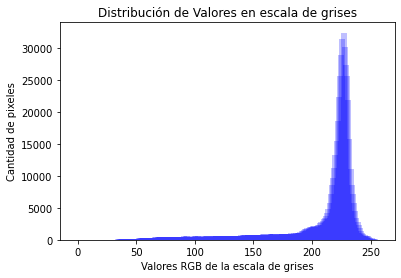

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars



Optimal threshold: 171
--------------------------------------
Tiempos de ejecucion: 13.50277617399999
Tiempo cargar imagen: 0.06823087399999395
Tiempo histograma: 5.166893483000024
Tiempo threshold: 0.36955307099998436
Tiempo optimal threshold: 0.001155934999985675
Restaurar imagen: 7.896932663999991


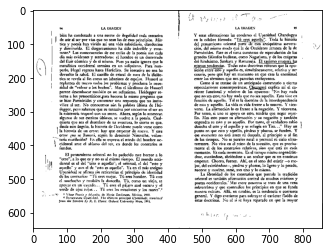

In [ ]:
if __name__ == '__main__':

  inicio = time.perf_counter()
  # Obteniendo la imagen en escala de grises y convirtiendola a arreglo
  s_cargar_imag = time.perf_counter()
  image = cv2.imread('pucp.jpg')
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  img = np.asarray(img)
  time_cargar_imag = time.perf_counter()-s_cargar_imag

  # Obteniendo y mostrando histograma
  s_hist = time.perf_counter()
  h = Hist(img)
  time_hist = time.perf_counter()-s_hist

  # Obteniendo las varianzas de cada umbral
  s_threshold = time.perf_counter()
  threshold(h)
  time_threshold = time.perf_counter()-s_threshold

  # Obteniendo el umbral óptimo
  s_optimal_thres = time.perf_counter()
  op_thres = get_optimal_threshold()
  time_op_thres = time.perf_counter()-s_optimal_thres

  # Obteniendo y mostrando imagen modificada mediante el umbral hallado
  s_rest_imag = time.perf_counter()
  res = regenerate_img(img, op_thres)
  plt.imshow(res)
  plt.savefig("pucpMod.jpg",dpi = 500)
  time_rest_imag = time.perf_counter()-s_rest_imag
  tTotal = time.perf_counter()-inicio

  print('--------------------------------------')
  print(f'Tiempos de ejecucion: {tTotal}')
  print(f'Tiempo cargar imagen: {time_cargar_imag}')
  print(f'Tiempo histograma: {time_hist}')
  print(f'Tiempo hreshold: {time_threshold}')
  print(f'Tiempo optimal threshold: {time_op_thres}')
  print(f'Tiempo restaurar imagen: {time_rest_imag}')